(353, 5)


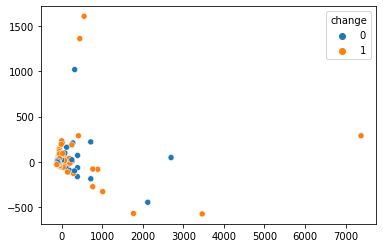

In [13]:
import praw
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.decomposition
import numpy as np
#from get_all_tickers import get_tickers as gt

import yfinance as yf
from datetime import datetime




#list_of_tickers = gt.get_tickers()

# msft = yf.Ticker("MSFT")
# msft.info
# hist = msft.history(period="max")
# print(hist)


def parsePost(body):
    nyse = pd.read_csv('nasdaq_screener_1617235748637.csv')
    nyse = nyse['Symbol'].to_numpy()
    amex = pd.read_csv('nasdaq_screener_1617235744315.csv')
    amex = amex['Symbol'].to_numpy()
    nasdaq = pd.read_csv('nasdaq_screener_1617235740645.csv')
    nasdaq = nasdaq['Symbol'].to_numpy()
    body = body.split()
    for word in body:
        if word == word.upper() and word[1:].isalpha() and word != "TLDR":
            if word in nyse or word in nasdaq or word in amex:
                tick = yf.Ticker(word)
                hist = tick.history(period = "max")
                if hist.empty:
                    pass
                #print(word + " empty")
                else:
                #print(hist)
                    return word
            
    
    
def scrap(ml_subreddit):
    posts = []
    stocks = []
    for post in ml_subreddit.new(limit=10000):
        body = post.selftext
        tickPost = parsePost(body)
        if tickPost != None:
            # ticker = yf.Ticker(tickPost)
            price = addFinance(tickPost, post.created_utc)
            #price = str(price)+'%'
            stocks.append(tickPost)
            created = convertUnix(post.created_utc)
            posts.append([tickPost, post.score,  post.num_comments, created, price])
    posts = pd.DataFrame(posts,columns=['ticker', 'score', 'num_comments', 'created', 'change'])
    #print(posts)
    print(posts.shape)
    return posts

def convertUnix(created, cost = 0):
    if cost == 1:
        return datetime.utcfromtimestamp(created).strftime('%Y-%m-%d')
    else:
        return datetime.utcfromtimestamp(created).strftime('%Y-%m-%d %H:%M:%S')

def addFinance(post, created):
      # date = datetime.utcfromtimestamp(created).strftime('%Y-%m-%d')
    date = convertUnix(created, 1)
    tick = yf.Ticker(post)
    hist = tick.history(start = date)
    open = hist['Open'].values[0]
    close = hist['Close'].values[0]
    #return ((close - open)/open) * 100
    if open - close > 0:
        return 1
    else:
        return 0

def classificationPairplot(posts):
    posts.drop('ticker', axis = 1)
    posts.drop('created', axis = 1)
    sns.pairplot(data = posts, hue = 'change')
    plt.savefig('ClassificationPairplot.pdf')

def regressionPlot(posts):
    #sns.regplot(x='score', y='change', data=posts);
    #plt.savefig('UpvotesRegression.pdf')
    #plt.clf()
    #plt.figure()
    #sns.regplot(x='num_comments', y='change', data=posts);
    #plt.savefig('CommentsRegression.pdf')
    #plt.clf()
    #plt.figure()
    sns.regplot(x='score', y='num_comments', data=posts);
    plt.savefig('CommentsVsUpvotes.pdf')

def crossValMAE(posts):
    #posts.drop('ticker', axis = 1)
    #posts.drop('created', axis = 1)
    y = posts['change']
    X = posts.drop(['change', 'ticker', 'created'], axis = 1)
    print(X)
    ss = sklearn.preprocessing.StandardScaler()
    X = ss.fit_transform(X)
    sgd = sklearn.linear_model.SGDRegressor()
    scores = sklearn.model_selection.cross_val_score(sgd, X, y, cv=5, scoring="neg_mean_absolute_error")
    print("The average 5-fold cross-validation MAE is:", -np.mean(scores))
    
def pcaPlot(posts):
    y = posts['change']
    X = posts.drop(['change', 'ticker', 'created'], axis = 1)
    pca = sklearn.decomposition.PCA(n_components = 2)
    X_2D = pca.fit_transform(X)
    sns.scatterplot(x = X_2D[:,0], y = X_2D[:,1], hue = y)
    plt.savefig('PCAplot.pdf')
    

def main():
    reddit = praw.Reddit(
    client_id="2SVXasRHimuAAg",
    client_secret="eN6CKPiIjEwRo-4GkUoimvOdFdguMA",
    user_agent="mlcolgate",)
    ml_subreddit = reddit.subreddit('stocks')
    posts = scrap(ml_subreddit)
    pcaPlot(posts)

#     msft = yf.Ticker("TLDR")
#     hist = msft.history(period="max")
#     print(hist)

    
    
    

    
if __name__ == "__main__":
    main()
    
    